In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
        {'im':'t1t2','fe':['k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_1_0_e_e_0_0_1_connectivity_data_norm_e_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4012456, 1104)
(4012456, 8)
validation
(542352, 1104)
(542352, 8)
test
(574820, 1104)
(574820, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1104)]            0         


 dense (Dense)               (None, 2048)              2263040   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 5051272 (19.27 MB)


Trainable params: 5051272 (19.27 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/41 [..............................] - ETA: 6:45 - loss: 2.1197 - STD: 0.0393 - MAE: 0.2185

 2/41 [>.............................] - ETA: 17s - loss: 2.0881 - STD: 0.0419 - MAE: 0.2172 

 3/41 [=>............................] - ETA: 16s - loss: 2.0848 - STD: 0.0462 - MAE: 0.2167

 4/41 [=>............................] - ETA: 16s - loss: 2.0833 - STD: 0.0470 - MAE: 0.2165

 5/41 [==>...........................] - ETA: 15s - loss: 2.0799 - STD: 0.0458 - MAE: 0.2165

 6/41 [===>..........................] - ETA: 15s - loss: 2.0757 - STD: 0.0437 - MAE: 0.2165

 7/41 [====>.........................] - ETA: 14s - loss: 2.0724 - STD: 0.0419 - MAE: 0.2166

 8/41 [====>.........................] - ETA: 14s - loss: 2.0704 - STD: 0.0405 - MAE: 0.2166

 9/41 [=====>........................] - ETA: 14s - loss: 2.0693 - STD: 0.0396 - MAE: 0.2167

10/41 [======>.......................] - ETA: 13s - loss: 2.0684 - STD: 0.0388 - MAE: 0.2167

11/41 [=======>......................] - ETA: 13s - loss: 2.0675 - STD: 0.0382 - MAE: 0.2167

12/41 [=======>......................] - ETA: 12s - loss: 2.0663 - STD: 0.0375 - MAE: 0.2167

13/41 [========>.....................] - ETA: 12s - loss: 2.0650 - STD: 0.0370 - MAE: 0.2167

14/41 [=========>....................] - ETA: 11s - loss: 2.0638 - STD: 0.0367 - MAE: 0.2167

15/41 [=========>....................] - ETA: 11s - loss: 2.0626 - STD: 0.0365 - MAE: 0.2167

16/41 [==========>...................] - ETA: 11s - loss: 2.0617 - STD: 0.0366 - MAE: 0.2167

17/41 [===========>..................] - ETA: 10s - loss: 2.0608 - STD: 0.0367 - MAE: 0.2166

18/41 [============>.................] - ETA: 10s - loss: 2.0598 - STD: 0.0368 - MAE: 0.2166

19/41 [============>.................] - ETA: 9s - loss: 2.0588 - STD: 0.0368 - MAE: 0.2166 

20/41 [=============>................] - ETA: 9s - loss: 2.0574 - STD: 0.0367 - MAE: 0.2165

21/41 [==============>...............] - ETA: 8s - loss: 2.0556 - STD: 0.0365 - MAE: 0.2165

22/41 [===============>..............] - ETA: 8s - loss: 2.0537 - STD: 0.0363 - MAE: 0.2164

23/41 [===============>..............] - ETA: 7s - loss: 2.0514 - STD: 0.0363 - MAE: 0.2163

24/41 [================>.............] - ETA: 7s - loss: 2.0488 - STD: 0.0363 - MAE: 0.2162

25/41 [=================>............] - ETA: 7s - loss: 2.0459 - STD: 0.0365 - MAE: 0.2161

26/41 [==================>...........] - ETA: 6s - loss: 2.0427 - STD: 0.0369 - MAE: 0.2160

27/41 [==================>...........] - ETA: 6s - loss: 2.0423 - STD: 0.0375 - MAE: 0.2158

28/41 [===================>..........] - ETA: 6s - loss: 2.0383 - STD: 0.0381 - MAE: 0.2156

29/41 [====================>.........] - ETA: 5s - loss: 2.0341 - STD: 0.0390 - MAE: 0.2154

30/41 [====================>.........] - ETA: 5s - loss: 2.0299 - STD: 0.0399 - MAE: 0.2152

31/41 [=====================>........] - ETA: 4s - loss: 2.0255 - STD: 0.0407 - MAE: 0.2150

32/41 [======================>.......] - ETA: 4s - loss: 2.0210 - STD: 0.0414 - MAE: 0.2148

33/41 [=======================>......] - ETA: 3s - loss: 2.0165 - STD: 0.0421 - MAE: 0.2146

34/41 [=======================>......] - ETA: 3s - loss: 2.0119 - STD: 0.0428 - MAE: 0.2144

35/41 [========================>.....] - ETA: 2s - loss: 2.0073 - STD: 0.0436 - MAE: 0.2141

36/41 [=========================>....] - ETA: 2s - loss: 2.0026 - STD: 0.0446 - MAE: 0.2139

37/41 [==========================>...] - ETA: 1s - loss: 1.9979 - STD: 0.0455 - MAE: 0.2136

38/41 [==========================>...] - ETA: 1s - loss: 1.9931 - STD: 0.0465 - MAE: 0.2134

39/41 [===========================>..] - ETA: 0s - loss: 1.9882 - STD: 0.0473 - MAE: 0.2131

40/41 [============================>.] - ETA: 0s - loss: 1.9834 - STD: 0.0482 - MAE: 0.2129

41/41 [==============================] - ETA: 0s - loss: 1.9785 - STD: 0.0490 - MAE: 0.2126

41/41 [==============================] - 33s 574ms/step - loss: 1.9785 - STD: 0.0490 - MAE: 0.2126 - val_loss: 1.7038 - val_STD: 0.0893 - val_MAE: 0.1990


Epoch 2/10000


 1/41 [..............................] - ETA: 33s - loss: 1.7716 - STD: 0.0845 - MAE: 0.2019

 2/41 [>.............................] - ETA: 17s - loss: 1.7677 - STD: 0.0870 - MAE: 0.2014

 3/41 [=>............................] - ETA: 16s - loss: 1.7625 - STD: 0.0876 - MAE: 0.2011

 4/41 [=>............................] - ETA: 16s - loss: 1.7554 - STD: 0.0884 - MAE: 0.2008

 5/41 [==>...........................] - ETA: 15s - loss: 1.7485 - STD: 0.0888 - MAE: 0.2005

 6/41 [===>..........................] - ETA: 15s - loss: 1.7419 - STD: 0.0893 - MAE: 0.2003

 7/41 [====>.........................] - ETA: 14s - loss: 1.7360 - STD: 0.0904 - MAE: 0.1999

 8/41 [====>.........................] - ETA: 14s - loss: 1.7324 - STD: 0.0910 - MAE: 0.1997

 9/41 [=====>........................] - ETA: 14s - loss: 1.7280 - STD: 0.0921 - MAE: 0.1994

10/41 [======>.......................] - ETA: 13s - loss: 1.7222 - STD: 0.0925 - MAE: 0.1992

11/41 [=======>......................] - ETA: 13s - loss: 1.7173 - STD: 0.0928 - MAE: 0.1990

12/41 [=======>......................] - ETA: 12s - loss: 1.7133 - STD: 0.0935 - MAE: 0.1987

13/41 [========>.....................] - ETA: 12s - loss: 1.7082 - STD: 0.0941 - MAE: 0.1985

14/41 [=========>....................] - ETA: 11s - loss: 1.7036 - STD: 0.0947 - MAE: 0.1982

15/41 [=========>....................] - ETA: 11s - loss: 1.6993 - STD: 0.0954 - MAE: 0.1980

16/41 [==========>...................] - ETA: 11s - loss: 1.6946 - STD: 0.0957 - MAE: 0.1977

17/41 [===========>..................] - ETA: 10s - loss: 1.6894 - STD: 0.0962 - MAE: 0.1975

18/41 [============>.................] - ETA: 10s - loss: 1.6846 - STD: 0.0968 - MAE: 0.1972

19/41 [============>.................] - ETA: 9s - loss: 1.6797 - STD: 0.0974 - MAE: 0.1969 

20/41 [=============>................] - ETA: 9s - loss: 1.6744 - STD: 0.0979 - MAE: 0.1966

21/41 [==============>...............] - ETA: 8s - loss: 1.6689 - STD: 0.0985 - MAE: 0.1962

22/41 [===============>..............] - ETA: 8s - loss: 1.6636 - STD: 0.0992 - MAE: 0.1959

23/41 [===============>..............] - ETA: 7s - loss: 1.6578 - STD: 0.0998 - MAE: 0.1955

24/41 [================>.............] - ETA: 7s - loss: 1.6517 - STD: 0.1005 - MAE: 0.1951

25/41 [=================>............] - ETA: 7s - loss: 1.6458 - STD: 0.1013 - MAE: 0.1948

26/41 [==================>...........] - ETA: 6s - loss: 1.6401 - STD: 0.1021 - MAE: 0.1944

27/41 [==================>...........] - ETA: 6s - loss: 1.6347 - STD: 0.1030 - MAE: 0.1939

28/41 [===================>..........] - ETA: 5s - loss: 1.6288 - STD: 0.1038 - MAE: 0.1935

29/41 [====================>.........] - ETA: 5s - loss: 1.6228 - STD: 0.1047 - MAE: 0.1931

30/41 [====================>.........] - ETA: 4s - loss: 1.6174 - STD: 0.1056 - MAE: 0.1927

31/41 [=====================>........] - ETA: 4s - loss: 1.6120 - STD: 0.1065 - MAE: 0.1923

32/41 [======================>.......] - ETA: 3s - loss: 1.6061 - STD: 0.1073 - MAE: 0.1918

33/41 [=======================>......] - ETA: 3s - loss: 1.6053 - STD: 0.1082 - MAE: 0.1914

34/41 [=======================>......] - ETA: 3s - loss: 1.5999 - STD: 0.1091 - MAE: 0.1910

35/41 [========================>.....] - ETA: 2s - loss: 1.5943 - STD: 0.1099 - MAE: 0.1906

36/41 [=========================>....] - ETA: 2s - loss: 1.5885 - STD: 0.1107 - MAE: 0.1902

37/41 [==========================>...] - ETA: 1s - loss: 1.5831 - STD: 0.1116 - MAE: 0.1898

38/41 [==========================>...] - ETA: 1s - loss: 1.5781 - STD: 0.1123 - MAE: 0.1894

39/41 [===========================>..] - ETA: 0s - loss: 1.5728 - STD: 0.1131 - MAE: 0.1890

40/41 [============================>.] - ETA: 0s - loss: 1.5676 - STD: 0.1138 - MAE: 0.1887

41/41 [==============================] - ETA: 0s - loss: 1.5629 - STD: 0.1145 - MAE: 0.1883

41/41 [==============================] - 20s 472ms/step - loss: 1.5629 - STD: 0.1145 - MAE: 0.1883 - val_loss: 1.3264 - val_STD: 0.1488 - val_MAE: 0.1708


Epoch 3/10000


 1/41 [..............................] - ETA: 33s - loss: 1.3724 - STD: 0.1463 - MAE: 0.1734

 2/41 [>.............................] - ETA: 17s - loss: 1.3677 - STD: 0.1458 - MAE: 0.1733

 3/41 [=>............................] - ETA: 16s - loss: 1.3646 - STD: 0.1460 - MAE: 0.1731

 4/41 [=>............................] - ETA: 16s - loss: 1.3638 - STD: 0.1463 - MAE: 0.1729

 5/41 [==>...........................] - ETA: 15s - loss: 1.3677 - STD: 0.1470 - MAE: 0.1729

 6/41 [===>..........................] - ETA: 15s - loss: 1.3722 - STD: 0.1469 - MAE: 0.1731

 7/41 [====>.........................] - ETA: 15s - loss: 1.3712 - STD: 0.1476 - MAE: 0.1729

 8/41 [====>.........................] - ETA: 14s - loss: 1.3679 - STD: 0.1479 - MAE: 0.1727

 9/41 [=====>........................] - ETA: 14s - loss: 1.3685 - STD: 0.1478 - MAE: 0.1727

10/41 [======>.......................] - ETA: 13s - loss: 1.3657 - STD: 0.1480 - MAE: 0.1725

11/41 [=======>......................] - ETA: 13s - loss: 1.3642 - STD: 0.1481 - MAE: 0.1724

12/41 [=======>......................] - ETA: 12s - loss: 1.3625 - STD: 0.1481 - MAE: 0.1723

13/41 [========>.....................] - ETA: 12s - loss: 1.3600 - STD: 0.1482 - MAE: 0.1722

14/41 [=========>....................] - ETA: 11s - loss: 1.3588 - STD: 0.1485 - MAE: 0.1720

15/41 [=========>....................] - ETA: 11s - loss: 1.3565 - STD: 0.1487 - MAE: 0.1719

16/41 [==========>...................] - ETA: 11s - loss: 1.3549 - STD: 0.1489 - MAE: 0.1718

17/41 [===========>..................] - ETA: 10s - loss: 1.3534 - STD: 0.1491 - MAE: 0.1716

18/41 [============>.................] - ETA: 9s - loss: 1.3531 - STD: 0.1493 - MAE: 0.1715 

19/41 [============>.................] - ETA: 9s - loss: 1.3520 - STD: 0.1494 - MAE: 0.1714

20/41 [=============>................] - ETA: 8s - loss: 1.3501 - STD: 0.1496 - MAE: 0.1713

21/41 [==============>...............] - ETA: 8s - loss: 1.3485 - STD: 0.1498 - MAE: 0.1711

22/41 [===============>..............] - ETA: 8s - loss: 1.3468 - STD: 0.1500 - MAE: 0.1710

23/41 [===============>..............] - ETA: 7s - loss: 1.3454 - STD: 0.1501 - MAE: 0.1709

24/41 [================>.............] - ETA: 7s - loss: 1.3439 - STD: 0.1504 - MAE: 0.1707

25/41 [=================>............] - ETA: 6s - loss: 1.3424 - STD: 0.1506 - MAE: 0.1706

26/41 [==================>...........] - ETA: 6s - loss: 1.3411 - STD: 0.1507 - MAE: 0.1705

27/41 [==================>...........] - ETA: 5s - loss: 1.3394 - STD: 0.1509 - MAE: 0.1704

28/41 [===================>..........] - ETA: 5s - loss: 1.3380 - STD: 0.1511 - MAE: 0.1702

29/41 [====================>.........] - ETA: 5s - loss: 1.3365 - STD: 0.1513 - MAE: 0.1701

30/41 [====================>.........] - ETA: 4s - loss: 1.3352 - STD: 0.1515 - MAE: 0.1700

31/41 [=====================>........] - ETA: 4s - loss: 1.3341 - STD: 0.1517 - MAE: 0.1699

32/41 [======================>.......] - ETA: 3s - loss: 1.3327 - STD: 0.1519 - MAE: 0.1698

33/41 [=======================>......] - ETA: 3s - loss: 1.3316 - STD: 0.1520 - MAE: 0.1696

34/41 [=======================>......] - ETA: 3s - loss: 1.3303 - STD: 0.1523 - MAE: 0.1695

35/41 [========================>.....] - ETA: 2s - loss: 1.3291 - STD: 0.1525 - MAE: 0.1694

36/41 [=========================>....] - ETA: 2s - loss: 1.3278 - STD: 0.1526 - MAE: 0.1693

37/41 [==========================>...] - ETA: 1s - loss: 1.3265 - STD: 0.1528 - MAE: 0.1692

38/41 [==========================>...] - ETA: 1s - loss: 1.3253 - STD: 0.1530 - MAE: 0.1690

39/41 [===========================>..] - ETA: 0s - loss: 1.3241 - STD: 0.1532 - MAE: 0.1689

40/41 [============================>.] - ETA: 0s - loss: 1.3233 - STD: 0.1534 - MAE: 0.1688

41/41 [==============================] - ETA: 0s - loss: 1.3225 - STD: 0.1535 - MAE: 0.1687

41/41 [==============================] - 20s 483ms/step - loss: 1.3225 - STD: 0.1535 - MAE: 0.1687 - val_loss: 1.2849 - val_STD: 0.1641 - val_MAE: 0.1643


Epoch 4/10000


 1/41 [..............................] - ETA: 33s - loss: 1.3177 - STD: 0.1606 - MAE: 0.1661

 2/41 [>.............................] - ETA: 17s - loss: 1.3169 - STD: 0.1612 - MAE: 0.1658

 3/41 [=>............................] - ETA: 16s - loss: 1.3105 - STD: 0.1615 - MAE: 0.1654

 4/41 [=>............................] - ETA: 16s - loss: 1.2997 - STD: 0.1616 - MAE: 0.1649

 5/41 [==>...........................] - ETA: 15s - loss: 1.2964 - STD: 0.1617 - MAE: 0.1647

 6/41 [===>..........................] - ETA: 15s - loss: 1.2959 - STD: 0.1620 - MAE: 0.1646

 7/41 [====>.........................] - ETA: 15s - loss: 1.2941 - STD: 0.1621 - MAE: 0.1645

 8/41 [====>.........................] - ETA: 14s - loss: 1.2909 - STD: 0.1621 - MAE: 0.1643

 9/41 [=====>........................] - ETA: 14s - loss: 1.2881 - STD: 0.1622 - MAE: 0.1642

10/41 [======>.......................] - ETA: 13s - loss: 1.2868 - STD: 0.1623 - MAE: 0.1641

11/41 [=======>......................] - ETA: 13s - loss: 1.2848 - STD: 0.1624 - MAE: 0.1640

12/41 [=======>......................] - ETA: 12s - loss: 1.2827 - STD: 0.1625 - MAE: 0.1638

13/41 [========>.....................] - ETA: 12s - loss: 1.2810 - STD: 0.1627 - MAE: 0.1637

14/41 [=========>....................] - ETA: 11s - loss: 1.2798 - STD: 0.1628 - MAE: 0.1636

15/41 [=========>....................] - ETA: 11s - loss: 1.2784 - STD: 0.1629 - MAE: 0.1635

16/41 [==========>...................] - ETA: 11s - loss: 1.2772 - STD: 0.1629 - MAE: 0.1634

17/41 [===========>..................] - ETA: 10s - loss: 1.2758 - STD: 0.1630 - MAE: 0.1633

18/41 [============>.................] - ETA: 10s - loss: 1.2747 - STD: 0.1631 - MAE: 0.1633

19/41 [============>.................] - ETA: 9s - loss: 1.2732 - STD: 0.1632 - MAE: 0.1631 

20/41 [=============>................] - ETA: 9s - loss: 1.2720 - STD: 0.1633 - MAE: 0.1631

21/41 [==============>...............] - ETA: 8s - loss: 1.2706 - STD: 0.1635 - MAE: 0.1629

22/41 [===============>..............] - ETA: 8s - loss: 1.2704 - STD: 0.1636 - MAE: 0.1628

23/41 [===============>..............] - ETA: 7s - loss: 1.2692 - STD: 0.1638 - MAE: 0.1627

24/41 [================>.............] - ETA: 7s - loss: 1.2681 - STD: 0.1639 - MAE: 0.1626

25/41 [=================>............] - ETA: 6s - loss: 1.2672 - STD: 0.1640 - MAE: 0.1625

26/41 [==================>...........] - ETA: 6s - loss: 1.2660 - STD: 0.1641 - MAE: 0.1624

27/41 [==================>...........] - ETA: 5s - loss: 1.2650 - STD: 0.1643 - MAE: 0.1624

28/41 [===================>..........] - ETA: 5s - loss: 1.2641 - STD: 0.1644 - MAE: 0.1623

29/41 [====================>.........] - ETA: 5s - loss: 1.2632 - STD: 0.1645 - MAE: 0.1622

30/41 [====================>.........] - ETA: 4s - loss: 1.2625 - STD: 0.1646 - MAE: 0.1621

31/41 [=====================>........] - ETA: 4s - loss: 1.2620 - STD: 0.1647 - MAE: 0.1621

32/41 [======================>.......] - ETA: 3s - loss: 1.2615 - STD: 0.1649 - MAE: 0.1620

33/41 [=======================>......] - ETA: 3s - loss: 1.2614 - STD: 0.1650 - MAE: 0.1619

34/41 [=======================>......] - ETA: 3s - loss: 1.2612 - STD: 0.1651 - MAE: 0.1619

35/41 [========================>.....] - ETA: 2s - loss: 1.2610 - STD: 0.1653 - MAE: 0.1618

36/41 [=========================>....] - ETA: 2s - loss: 1.2604 - STD: 0.1654 - MAE: 0.1617

37/41 [==========================>...] - ETA: 1s - loss: 1.2595 - STD: 0.1655 - MAE: 0.1617

38/41 [==========================>...] - ETA: 1s - loss: 1.2588 - STD: 0.1656 - MAE: 0.1616

39/41 [===========================>..] - ETA: 0s - loss: 1.2582 - STD: 0.1658 - MAE: 0.1615

40/41 [============================>.] - ETA: 0s - loss: 1.2577 - STD: 0.1659 - MAE: 0.1614

41/41 [==============================] - ETA: 0s - loss: 1.2572 - STD: 0.1660 - MAE: 0.1614

41/41 [==============================] - 20s 474ms/step - loss: 1.2572 - STD: 0.1660 - MAE: 0.1614 - val_loss: 1.1986 - val_STD: 0.1750 - val_MAE: 0.1560


Epoch 5/10000


 1/41 [..............................] - ETA: 34s - loss: 1.2229 - STD: 0.1706 - MAE: 0.1581

 2/41 [>.............................] - ETA: 17s - loss: 1.2210 - STD: 0.1708 - MAE: 0.1579

 3/41 [=>............................] - ETA: 16s - loss: 1.2245 - STD: 0.1714 - MAE: 0.1579

 4/41 [=>............................] - ETA: 16s - loss: 1.2272 - STD: 0.1716 - MAE: 0.1580

 5/41 [==>...........................] - ETA: 16s - loss: 1.2280 - STD: 0.1714 - MAE: 0.1580

 6/41 [===>..........................] - ETA: 15s - loss: 1.2258 - STD: 0.1715 - MAE: 0.1579

 7/41 [====>.........................] - ETA: 15s - loss: 1.2244 - STD: 0.1715 - MAE: 0.1578

 8/41 [====>.........................] - ETA: 14s - loss: 1.2246 - STD: 0.1717 - MAE: 0.1577

 9/41 [=====>........................] - ETA: 14s - loss: 1.2250 - STD: 0.1718 - MAE: 0.1577

10/41 [======>.......................] - ETA: 13s - loss: 1.2245 - STD: 0.1720 - MAE: 0.1576

11/41 [=======>......................] - ETA: 13s - loss: 1.2240 - STD: 0.1720 - MAE: 0.1576

12/41 [=======>......................] - ETA: 12s - loss: 1.2232 - STD: 0.1722 - MAE: 0.1575

13/41 [========>.....................] - ETA: 12s - loss: 1.2228 - STD: 0.1722 - MAE: 0.1574

14/41 [=========>....................] - ETA: 11s - loss: 1.2218 - STD: 0.1724 - MAE: 0.1574

15/41 [=========>....................] - ETA: 11s - loss: 1.2202 - STD: 0.1724 - MAE: 0.1573

16/41 [==========>...................] - ETA: 11s - loss: 1.2191 - STD: 0.1724 - MAE: 0.1572

17/41 [===========>..................] - ETA: 10s - loss: 1.2188 - STD: 0.1725 - MAE: 0.1572

18/41 [============>.................] - ETA: 10s - loss: 1.2180 - STD: 0.1725 - MAE: 0.1571

19/41 [============>.................] - ETA: 9s - loss: 1.2180 - STD: 0.1727 - MAE: 0.1570 

20/41 [=============>................] - ETA: 8s - loss: 1.2169 - STD: 0.1728 - MAE: 0.1569

21/41 [==============>...............] - ETA: 8s - loss: 1.2160 - STD: 0.1728 - MAE: 0.1569

22/41 [===============>..............] - ETA: 8s - loss: 1.2149 - STD: 0.1729 - MAE: 0.1568

23/41 [===============>..............] - ETA: 7s - loss: 1.2140 - STD: 0.1730 - MAE: 0.1567

24/41 [================>.............] - ETA: 7s - loss: 1.2131 - STD: 0.1731 - MAE: 0.1566

25/41 [=================>............] - ETA: 6s - loss: 1.2120 - STD: 0.1732 - MAE: 0.1565

26/41 [==================>...........] - ETA: 6s - loss: 1.2113 - STD: 0.1733 - MAE: 0.1565

27/41 [==================>...........] - ETA: 6s - loss: 1.2107 - STD: 0.1734 - MAE: 0.1564

28/41 [===================>..........] - ETA: 5s - loss: 1.2109 - STD: 0.1734 - MAE: 0.1564

29/41 [====================>.........] - ETA: 5s - loss: 1.2117 - STD: 0.1736 - MAE: 0.1564

30/41 [====================>.........] - ETA: 4s - loss: 1.2132 - STD: 0.1736 - MAE: 0.1564

31/41 [=====================>........] - ETA: 4s - loss: 1.2134 - STD: 0.1737 - MAE: 0.1564

32/41 [======================>.......] - ETA: 3s - loss: 1.2127 - STD: 0.1738 - MAE: 0.1563

33/41 [=======================>......] - ETA: 3s - loss: 1.2123 - STD: 0.1739 - MAE: 0.1563

34/41 [=======================>......] - ETA: 3s - loss: 1.2123 - STD: 0.1740 - MAE: 0.1562

35/41 [========================>.....] - ETA: 2s - loss: 1.2121 - STD: 0.1741 - MAE: 0.1562

36/41 [=========================>....] - ETA: 2s - loss: 1.2113 - STD: 0.1741 - MAE: 0.1562

37/41 [==========================>...] - ETA: 1s - loss: 1.2112 - STD: 0.1742 - MAE: 0.1561

38/41 [==========================>...] - ETA: 1s - loss: 1.2107 - STD: 0.1743 - MAE: 0.1561

39/41 [===========================>..] - ETA: 0s - loss: 1.2098 - STD: 0.1744 - MAE: 0.1560

40/41 [============================>.] - ETA: 0s - loss: 1.2093 - STD: 0.1745 - MAE: 0.1559

41/41 [==============================] - ETA: 0s - loss: 1.2093 - STD: 0.1745 - MAE: 0.1559

41/41 [==============================] - 20s 474ms/step - loss: 1.2093 - STD: 0.1745 - MAE: 0.1559 - val_loss: 1.1782 - val_STD: 0.1833 - val_MAE: 0.1509


Epoch 6/10000


 1/41 [..............................] - ETA: 25s - loss: 1.1954 - STD: 0.1794 - MAE: 0.1533

 2/41 [>.............................] - ETA: 17s - loss: 1.1935 - STD: 0.1793 - MAE: 0.1533

 3/41 [=>............................] - ETA: 16s - loss: 1.1953 - STD: 0.1787 - MAE: 0.1536

 4/41 [=>............................] - ETA: 16s - loss: 1.1924 - STD: 0.1785 - MAE: 0.1535

 5/41 [==>...........................] - ETA: 15s - loss: 1.1890 - STD: 0.1783 - MAE: 0.1534

 6/41 [===>..........................] - ETA: 15s - loss: 1.1884 - STD: 0.1782 - MAE: 0.1534

 7/41 [====>.........................] - ETA: 15s - loss: 1.1867 - STD: 0.1785 - MAE: 0.1533

 8/41 [====>.........................] - ETA: 14s - loss: 1.1837 - STD: 0.1785 - MAE: 0.1531

 9/41 [=====>........................] - ETA: 14s - loss: 1.1829 - STD: 0.1784 - MAE: 0.1531

10/41 [======>.......................] - ETA: 13s - loss: 1.1814 - STD: 0.1785 - MAE: 0.1530

11/41 [=======>......................] - ETA: 13s - loss: 1.1799 - STD: 0.1786 - MAE: 0.1529

12/41 [=======>......................] - ETA: 12s - loss: 1.1788 - STD: 0.1787 - MAE: 0.1528

13/41 [========>.....................] - ETA: 12s - loss: 1.1782 - STD: 0.1788 - MAE: 0.1527

14/41 [=========>....................] - ETA: 11s - loss: 1.1771 - STD: 0.1788 - MAE: 0.1527

15/41 [=========>....................] - ETA: 11s - loss: 1.1758 - STD: 0.1789 - MAE: 0.1526

16/41 [==========>...................] - ETA: 11s - loss: 1.1748 - STD: 0.1791 - MAE: 0.1524

17/41 [===========>..................] - ETA: 10s - loss: 1.1737 - STD: 0.1791 - MAE: 0.1524

18/41 [============>.................] - ETA: 10s - loss: 1.1726 - STD: 0.1792 - MAE: 0.1523

19/41 [============>.................] - ETA: 9s - loss: 1.1718 - STD: 0.1793 - MAE: 0.1522 

20/41 [=============>................] - ETA: 9s - loss: 1.1706 - STD: 0.1794 - MAE: 0.1521

21/41 [==============>...............] - ETA: 8s - loss: 1.1699 - STD: 0.1795 - MAE: 0.1520

22/41 [===============>..............] - ETA: 8s - loss: 1.1691 - STD: 0.1796 - MAE: 0.1520

23/41 [===============>..............] - ETA: 7s - loss: 1.1686 - STD: 0.1797 - MAE: 0.1519

24/41 [================>.............] - ETA: 7s - loss: 1.1683 - STD: 0.1798 - MAE: 0.1518

25/41 [=================>............] - ETA: 7s - loss: 1.1687 - STD: 0.1799 - MAE: 0.1518

26/41 [==================>...........] - ETA: 6s - loss: 1.1712 - STD: 0.1800 - MAE: 0.1519

27/41 [==================>...........] - ETA: 6s - loss: 1.1776 - STD: 0.1800 - MAE: 0.1522

28/41 [===================>..........] - ETA: 5s - loss: 1.1815 - STD: 0.1802 - MAE: 0.1523

29/41 [====================>.........] - ETA: 5s - loss: 1.1805 - STD: 0.1802 - MAE: 0.1522

30/41 [====================>.........] - ETA: 4s - loss: 1.1820 - STD: 0.1804 - MAE: 0.1523

31/41 [=====================>........] - ETA: 4s - loss: 1.1842 - STD: 0.1804 - MAE: 0.1523

32/41 [======================>.......] - ETA: 3s - loss: 1.1831 - STD: 0.1805 - MAE: 0.1523

33/41 [=======================>......] - ETA: 3s - loss: 1.1842 - STD: 0.1805 - MAE: 0.1523

34/41 [=======================>......] - ETA: 3s - loss: 1.1844 - STD: 0.1805 - MAE: 0.1523

35/41 [========================>.....] - ETA: 2s - loss: 1.1842 - STD: 0.1806 - MAE: 0.1522

36/41 [=========================>....] - ETA: 2s - loss: 1.1846 - STD: 0.1806 - MAE: 0.1522

37/41 [==========================>...] - ETA: 1s - loss: 1.1837 - STD: 0.1807 - MAE: 0.1522

38/41 [==========================>...] - ETA: 1s - loss: 1.1836 - STD: 0.1807 - MAE: 0.1522

39/41 [===========================>..] - ETA: 0s - loss: 1.1828 - STD: 0.1808 - MAE: 0.1521

40/41 [============================>.] - ETA: 0s - loss: 1.1822 - STD: 0.1808 - MAE: 0.1520

41/41 [==============================] - ETA: 0s - loss: 1.1818 - STD: 0.1809 - MAE: 0.1520

41/41 [==============================] - 20s 474ms/step - loss: 1.1818 - STD: 0.1809 - MAE: 0.1520 - val_loss: 1.1414 - val_STD: 0.1862 - val_MAE: 0.1479


Epoch 7/10000


 1/41 [..............................] - ETA: 25s - loss: 1.1449 - STD: 0.1808 - MAE: 0.1502

 2/41 [>.............................] - ETA: 17s - loss: 1.1545 - STD: 0.1815 - MAE: 0.1504

 3/41 [=>............................] - ETA: 16s - loss: 1.1501 - STD: 0.1822 - MAE: 0.1500

 4/41 [=>............................] - ETA: 16s - loss: 1.1517 - STD: 0.1822 - MAE: 0.1501

 5/41 [==>...........................] - ETA: 15s - loss: 1.1508 - STD: 0.1823 - MAE: 0.1500

 6/41 [===>..........................] - ETA: 15s - loss: 1.1489 - STD: 0.1827 - MAE: 0.1498

 7/41 [====>.........................] - ETA: 15s - loss: 1.1486 - STD: 0.1828 - MAE: 0.1497

 8/41 [====>.........................] - ETA: 14s - loss: 1.1472 - STD: 0.1829 - MAE: 0.1496

 9/41 [=====>........................] - ETA: 14s - loss: 1.1470 - STD: 0.1831 - MAE: 0.1495

10/41 [======>.......................] - ETA: 13s - loss: 1.1462 - STD: 0.1830 - MAE: 0.1495

11/41 [=======>......................] - ETA: 13s - loss: 1.1455 - STD: 0.1830 - MAE: 0.1495

12/41 [=======>......................] - ETA: 12s - loss: 1.1447 - STD: 0.1830 - MAE: 0.1494

13/41 [========>.....................] - ETA: 12s - loss: 1.1438 - STD: 0.1830 - MAE: 0.1494

14/41 [=========>....................] - ETA: 11s - loss: 1.1435 - STD: 0.1830 - MAE: 0.1494

15/41 [=========>....................] - ETA: 11s - loss: 1.1426 - STD: 0.1831 - MAE: 0.1493

16/41 [==========>...................] - ETA: 11s - loss: 1.1418 - STD: 0.1832 - MAE: 0.1492

17/41 [===========>..................] - ETA: 10s - loss: 1.1410 - STD: 0.1833 - MAE: 0.1491

18/41 [============>.................] - ETA: 10s - loss: 1.1403 - STD: 0.1834 - MAE: 0.1491

19/41 [============>.................] - ETA: 9s - loss: 1.1394 - STD: 0.1835 - MAE: 0.1490 

20/41 [=============>................] - ETA: 9s - loss: 1.1387 - STD: 0.1836 - MAE: 0.1489

21/41 [==============>...............] - ETA: 8s - loss: 1.1381 - STD: 0.1837 - MAE: 0.1488

22/41 [===============>..............] - ETA: 8s - loss: 1.1377 - STD: 0.1839 - MAE: 0.1487

23/41 [===============>..............] - ETA: 7s - loss: 1.1373 - STD: 0.1839 - MAE: 0.1487

24/41 [================>.............] - ETA: 7s - loss: 1.1373 - STD: 0.1841 - MAE: 0.1486

25/41 [=================>............] - ETA: 7s - loss: 1.1371 - STD: 0.1841 - MAE: 0.1486

26/41 [==================>...........] - ETA: 6s - loss: 1.1365 - STD: 0.1842 - MAE: 0.1485

27/41 [==================>...........] - ETA: 6s - loss: 1.1358 - STD: 0.1843 - MAE: 0.1485

28/41 [===================>..........] - ETA: 5s - loss: 1.1354 - STD: 0.1844 - MAE: 0.1484

29/41 [====================>.........] - ETA: 5s - loss: 1.1350 - STD: 0.1845 - MAE: 0.1483

30/41 [====================>.........] - ETA: 4s - loss: 1.1346 - STD: 0.1846 - MAE: 0.1483

31/41 [=====================>........] - ETA: 4s - loss: 1.1344 - STD: 0.1847 - MAE: 0.1482

32/41 [======================>.......] - ETA: 3s - loss: 1.1340 - STD: 0.1848 - MAE: 0.1482

33/41 [=======================>......] - ETA: 3s - loss: 1.1340 - STD: 0.1849 - MAE: 0.1481

34/41 [=======================>......] - ETA: 3s - loss: 1.1338 - STD: 0.1850 - MAE: 0.1481

35/41 [========================>.....] - ETA: 2s - loss: 1.1333 - STD: 0.1851 - MAE: 0.1480

36/41 [=========================>....] - ETA: 2s - loss: 1.1326 - STD: 0.1852 - MAE: 0.1479

37/41 [==========================>...] - ETA: 1s - loss: 1.1320 - STD: 0.1853 - MAE: 0.1479

38/41 [==========================>...] - ETA: 1s - loss: 1.1315 - STD: 0.1854 - MAE: 0.1478

39/41 [===========================>..] - ETA: 0s - loss: 1.1311 - STD: 0.1856 - MAE: 0.1477

40/41 [============================>.] - ETA: 0s - loss: 1.1306 - STD: 0.1856 - MAE: 0.1477

41/41 [==============================] - ETA: 0s - loss: 1.1300 - STD: 0.1858 - MAE: 0.1476

41/41 [==============================] - 20s 473ms/step - loss: 1.1300 - STD: 0.1858 - MAE: 0.1476 - val_loss: 1.1298 - val_STD: 0.1959 - val_MAE: 0.1434


Epoch 8/10000


 1/41 [..............................] - ETA: 25s - loss: 1.1061 - STD: 0.1894 - MAE: 0.1448

 2/41 [>.............................] - ETA: 17s - loss: 1.1127 - STD: 0.1901 - MAE: 0.1450

 3/41 [=>............................] - ETA: 16s - loss: 1.1175 - STD: 0.1898 - MAE: 0.1453

 4/41 [=>............................] - ETA: 16s - loss: 1.1279 - STD: 0.1906 - MAE: 0.1455

 5/41 [==>...........................] - ETA: 15s - loss: 1.1440 - STD: 0.1898 - MAE: 0.1467

 6/41 [===>..........................] - ETA: 15s - loss: 1.1540 - STD: 0.1905 - MAE: 0.1469

 7/41 [====>.........................] - ETA: 15s - loss: 1.1502 - STD: 0.1899 - MAE: 0.1470

 8/41 [====>.........................] - ETA: 14s - loss: 1.1477 - STD: 0.1893 - MAE: 0.1470

 9/41 [=====>........................] - ETA: 14s - loss: 1.1498 - STD: 0.1895 - MAE: 0.1471

10/41 [======>.......................] - ETA: 13s - loss: 1.1479 - STD: 0.1891 - MAE: 0.1471

11/41 [=======>......................] - ETA: 13s - loss: 1.1455 - STD: 0.1889 - MAE: 0.1471

12/41 [=======>......................] - ETA: 12s - loss: 1.1461 - STD: 0.1891 - MAE: 0.1470

13/41 [========>.....................] - ETA: 12s - loss: 1.1444 - STD: 0.1890 - MAE: 0.1470

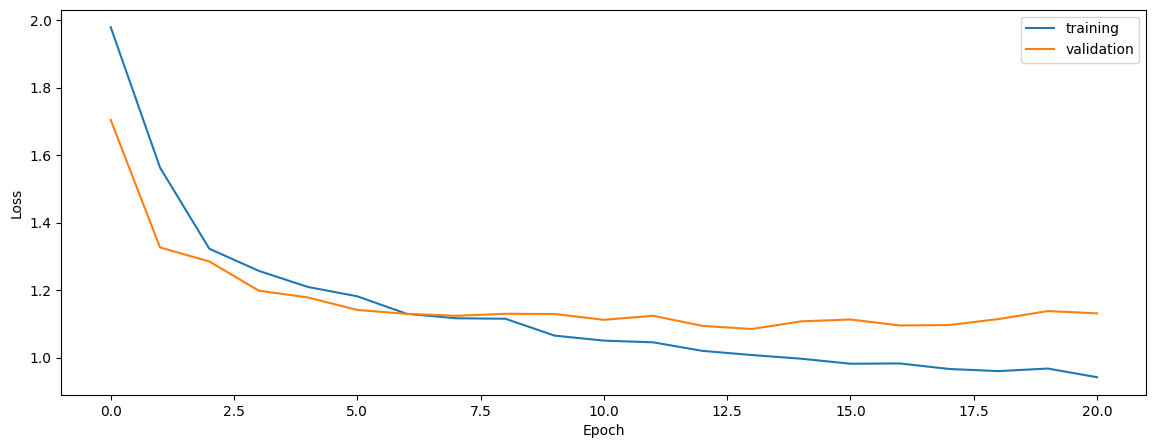

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_MSE_7_1_0_1_1_0_e_e_0_0_0_connectivity_data_norm_e_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_0_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1086687, 1104)
(1086687, 1)
validation
(145592, 1104)
(145592, 1)
test
(152076, 1104)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 1104)]            0         


 dense_6 (Dense)             (None, 2048)              2263040   


 dense_7 (Dense)             (None, 1024)              2098176   


 dense_8 (Dense)             (None, 512)               524800    


 dense_9 (Dense)             (None, 256)               131328    


 dense_10 (Dense)            (None, 128)               32896     


 dense_11 (Dense)            (None, 1)                 129       


Total params: 5050369 (19.27 MB)


Trainable params: 5050369 (19.27 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/11 [=>............................] - ETA: 18s - loss: 0.2837 - STD: 3.6428e-05 - MAE: 0.5038

 2/11 [====>.........................] - ETA: 3s - loss: 0.2506 - STD: 7.0564e-05 - MAE: 0.4729 

 3/11 [=======>......................] - ETA: 3s - loss: 0.2463 - STD: 6.6576e-05 - MAE: 0.4550

 4/11 [=========>....................] - ETA: 3s - loss: 0.2458 - STD: 6.1787e-05 - MAE: 0.4460

 5/11 [============>.................] - ETA: 2s - loss: 0.2436 - STD: 6.2035e-05 - MAE: 0.4410

 6/11 [===============>..............] - ETA: 2s - loss: 0.2401 - STD: 6.4705e-05 - MAE: 0.4389

 7/11 [==================>...........] - ETA: 1s - loss: 0.2368 - STD: 6.7094e-05 - MAE: 0.4393

 8/11 [====================>.........] - ETA: 1s - loss: 0.2347 - STD: 6.8158e-05 - MAE: 0.4415

 9/11 [=======================>......] - ETA: 2s - loss: 0.2338 - STD: 6.8186e-05 - MAE: 0.4440

10/11 [==========================>...] - ETA: 1s - loss: 0.2332 - STD: 6.7873e-05 - MAE: 0.4464

11/11 [==============================] - ETA: 0s - loss: 0.2324 - STD: 6.7569e-05 - MAE: 0.4480

11/11 [==============================] - 16s 1s/step - loss: 0.2324 - STD: 6.7569e-05 - MAE: 0.4480 - val_loss: 0.2246 - val_STD: 7.1401e-05 - val_MAE: 0.4640


Epoch 2/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.2208 - STD: 6.5833e-05 - MAE: 0.4578

 2/11 [====>.........................] - ETA: 4s - loss: 0.2192 - STD: 6.6062e-05 - MAE: 0.4536

 3/11 [=======>......................] - ETA: 3s - loss: 0.2185 - STD: 6.6093e-05 - MAE: 0.4493

 4/11 [=========>....................] - ETA: 2s - loss: 0.2186 - STD: 6.5770e-05 - MAE: 0.4457

 5/11 [============>.................] - ETA: 2s - loss: 0.2189 - STD: 6.5325e-05 - MAE: 0.4427

 6/11 [===============>..............] - ETA: 2s - loss: 0.2195 - STD: 6.5012e-05 - MAE: 0.4406

 7/11 [==================>...........] - ETA: 1s - loss: 0.2197 - STD: 6.4838e-05 - MAE: 0.4392

 8/11 [====================>.........] - ETA: 1s - loss: 0.2197 - STD: 6.4829e-05 - MAE: 0.4386

 9/11 [=======================>......] - ETA: 0s - loss: 0.2196 - STD: 6.4982e-05 - MAE: 0.4385

10/11 [==========================>...] - ETA: 0s - loss: 0.2194 - STD: 6.5270e-05 - MAE: 0.4389

11/11 [==============================] - ETA: 0s - loss: 0.2192 - STD: 6.5609e-05 - MAE: 0.4397

11/11 [==============================] - 6s 495ms/step - loss: 0.2192 - STD: 6.5609e-05 - MAE: 0.4397 - val_loss: 0.2221 - val_STD: 7.6067e-05 - val_MAE: 0.4582


Epoch 3/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.2183 - STD: 7.0255e-05 - MAE: 0.4516

 2/11 [====>.........................] - ETA: 3s - loss: 0.2187 - STD: 7.0790e-05 - MAE: 0.4528

 3/11 [=======>......................] - ETA: 3s - loss: 0.2189 - STD: 7.1538e-05 - MAE: 0.4534

 4/11 [=========>....................] - ETA: 3s - loss: 0.2188 - STD: 7.2364e-05 - MAE: 0.4533

 5/11 [============>.................] - ETA: 2s - loss: 0.2186 - STD: 7.3183e-05 - MAE: 0.4527

 6/11 [===============>..............] - ETA: 2s - loss: 0.2185 - STD: 7.4086e-05 - MAE: 0.4518

 7/11 [==================>...........] - ETA: 1s - loss: 0.2184 - STD: 7.5096e-05 - MAE: 0.4507

 8/11 [====================>.........] - ETA: 1s - loss: 0.2184 - STD: 7.6060e-05 - MAE: 0.4495

 9/11 [=======================>......] - ETA: 0s - loss: 0.2183 - STD: 7.7092e-05 - MAE: 0.4483

10/11 [==========================>...] - ETA: 0s - loss: 0.2183 - STD: 7.8178e-05 - MAE: 0.4472

11/11 [==============================] - ETA: 0s - loss: 0.2182 - STD: 7.9358e-05 - MAE: 0.4463

11/11 [==============================] - 6s 499ms/step - loss: 0.2182 - STD: 7.9358e-05 - MAE: 0.4463 - val_loss: 0.2214 - val_STD: 1.0319e-04 - val_MAE: 0.4463


Epoch 4/10000


 1/11 [=>............................] - ETA: 8s - loss: 0.2173 - STD: 9.4881e-05 - MAE: 0.4385

 2/11 [====>.........................] - ETA: 3s - loss: 0.2174 - STD: 9.7057e-05 - MAE: 0.4398

 3/11 [=======>......................] - ETA: 3s - loss: 0.2175 - STD: 9.9356e-05 - MAE: 0.4411

 4/11 [=========>....................] - ETA: 3s - loss: 0.2175 - STD: 1.0168e-04 - MAE: 0.4423

 5/11 [============>.................] - ETA: 2s - loss: 0.2175 - STD: 1.0408e-04 - MAE: 0.4433

 6/11 [===============>..............] - ETA: 2s - loss: 0.2175 - STD: 1.0655e-04 - MAE: 0.4441

 7/11 [==================>...........] - ETA: 1s - loss: 0.2175 - STD: 1.0905e-04 - MAE: 0.4448

 8/11 [====================>.........] - ETA: 1s - loss: 0.2175 - STD: 1.1170e-04 - MAE: 0.4453

 9/11 [=======================>......] - ETA: 0s - loss: 0.2176 - STD: 1.1441e-04 - MAE: 0.4456

10/11 [==========================>...] - ETA: 0s - loss: 0.2176 - STD: 1.1717e-04 - MAE: 0.4456

11/11 [==============================] - ETA: 0s - loss: 0.2175 - STD: 1.2002e-04 - MAE: 0.4454

11/11 [==============================] - 6s 495ms/step - loss: 0.2175 - STD: 1.2002e-04 - MAE: 0.4454 - val_loss: 0.2210 - val_STD: 1.6926e-04 - val_MAE: 0.4495


Epoch 5/10000


 1/11 [=>............................] - ETA: 8s - loss: 0.2172 - STD: 1.5571e-04 - MAE: 0.4424

 2/11 [====>.........................] - ETA: 3s - loss: 0.2173 - STD: 1.5946e-04 - MAE: 0.4418

 3/11 [=======>......................] - ETA: 3s - loss: 0.2174 - STD: 1.6406e-04 - MAE: 0.4415

 4/11 [=========>....................] - ETA: 2s - loss: 0.2175 - STD: 1.6847e-04 - MAE: 0.4415

 5/11 [============>.................] - ETA: 2s - loss: 0.2175 - STD: 1.7344e-04 - MAE: 0.4415

 6/11 [===============>..............] - ETA: 2s - loss: 0.2174 - STD: 1.7880e-04 - MAE: 0.4417

 7/11 [==================>...........] - ETA: 1s - loss: 0.2173 - STD: 1.8448e-04 - MAE: 0.4420

 8/11 [====================>.........] - ETA: 1s - loss: 0.2174 - STD: 1.9050e-04 - MAE: 0.4425

 9/11 [=======================>......] - ETA: 0s - loss: 0.2174 - STD: 1.9693e-04 - MAE: 0.4430

10/11 [==========================>...] - ETA: 0s - loss: 0.2174 - STD: 2.0375e-04 - MAE: 0.4433

11/11 [==============================] - ETA: 0s - loss: 0.2174 - STD: 2.1078e-04 - MAE: 0.4436

11/11 [==============================] - 6s 490ms/step - loss: 0.2174 - STD: 2.1078e-04 - MAE: 0.4436 - val_loss: 0.2210 - val_STD: 3.2613e-04 - val_MAE: 0.4528


Epoch 6/10000


 1/11 [=>............................] - ETA: 8s - loss: 0.2170 - STD: 2.9993e-04 - MAE: 0.4456

 2/11 [====>.........................] - ETA: 3s - loss: 0.2172 - STD: 3.0966e-04 - MAE: 0.4454

 3/11 [=======>......................] - ETA: 3s - loss: 0.2172 - STD: 3.2025e-04 - MAE: 0.4450

 4/11 [=========>....................] - ETA: 3s - loss: 0.2172 - STD: 3.3135e-04 - MAE: 0.4444

 5/11 [============>.................] - ETA: 2s - loss: 0.2172 - STD: 3.4344e-04 - MAE: 0.4440

 6/11 [===============>..............] - ETA: 2s - loss: 0.2172 - STD: 3.5658e-04 - MAE: 0.4437

 7/11 [==================>...........] - ETA: 1s - loss: 0.2173 - STD: 3.7101e-04 - MAE: 0.4436

 8/11 [====================>.........] - ETA: 1s - loss: 0.2174 - STD: 3.8645e-04 - MAE: 0.4436

 9/11 [=======================>......] - ETA: 0s - loss: 0.2172 - STD: 4.0305e-04 - MAE: 0.4435

10/11 [==========================>...] - ETA: 0s - loss: 0.2172 - STD: 4.2123e-04 - MAE: 0.4437

11/11 [==============================] - ETA: 0s - loss: 0.2173 - STD: 4.4088e-04 - MAE: 0.4439

11/11 [==============================] - 6s 497ms/step - loss: 0.2173 - STD: 4.4088e-04 - MAE: 0.4439 - val_loss: 0.2209 - val_STD: 7.5285e-04 - val_MAE: 0.4522


Epoch 7/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.2175 - STD: 6.9227e-04 - MAE: 0.4460

 2/11 [====>.........................] - ETA: 4s - loss: 0.2171 - STD: 7.2410e-04 - MAE: 0.4453

 3/11 [=======>......................] - ETA: 3s - loss: 0.2172 - STD: 7.5922e-04 - MAE: 0.4453

 4/11 [=========>....................] - ETA: 3s - loss: 0.2172 - STD: 7.9625e-04 - MAE: 0.4450

 5/11 [============>.................] - ETA: 2s - loss: 0.2171 - STD: 8.3696e-04 - MAE: 0.4447

 6/11 [===============>..............] - ETA: 2s - loss: 0.2171 - STD: 8.8143e-04 - MAE: 0.4445

 7/11 [==================>...........] - ETA: 1s - loss: 0.2171 - STD: 9.3064e-04 - MAE: 0.4443

 8/11 [====================>.........] - ETA: 1s - loss: 0.2170 - STD: 9.8497e-04 - MAE: 0.4441

 9/11 [=======================>......] - ETA: 0s - loss: 0.2170 - STD: 0.0010 - MAE: 0.4439    

10/11 [==========================>...] - ETA: 0s - loss: 0.2170 - STD: 0.0011 - MAE: 0.4439

11/11 [==============================] - ETA: 0s - loss: 0.2170 - STD: 0.0012 - MAE: 0.4439

11/11 [==============================] - 6s 497ms/step - loss: 0.2170 - STD: 0.0012 - MAE: 0.4439 - val_loss: 0.2204 - val_STD: 0.0024 - val_MAE: 0.4509


Epoch 8/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.2168 - STD: 0.0022 - MAE: 0.4441

 2/11 [====>.........................] - ETA: 3s - loss: 0.2169 - STD: 0.0024 - MAE: 0.4444

 3/11 [=======>......................] - ETA: 3s - loss: 0.2168 - STD: 0.0025 - MAE: 0.4444

 4/11 [=========>....................] - ETA: 2s - loss: 0.2167 - STD: 0.0027 - MAE: 0.4443

 5/11 [============>.................] - ETA: 2s - loss: 0.2166 - STD: 0.0029 - MAE: 0.4441

 6/11 [===============>..............] - ETA: 2s - loss: 0.2166 - STD: 0.0032 - MAE: 0.4440

 7/11 [==================>...........] - ETA: 1s - loss: 0.2165 - STD: 0.0034 - MAE: 0.4438

 8/11 [====================>.........] - ETA: 1s - loss: 0.2165 - STD: 0.0038 - MAE: 0.4436

 9/11 [=======================>......] - ETA: 0s - loss: 0.2163 - STD: 0.0041 - MAE: 0.4434

10/11 [==========================>...] - ETA: 0s - loss: 0.2162 - STD: 0.0045 - MAE: 0.4432

11/11 [==============================] - ETA: 0s - loss: 0.2161 - STD: 0.0050 - MAE: 0.4430

11/11 [==============================] - 6s 498ms/step - loss: 0.2161 - STD: 0.0050 - MAE: 0.4430 - val_loss: 0.2178 - val_STD: 0.0125 - val_MAE: 0.4475


Epoch 9/10000


 1/11 [=>............................] - ETA: 7s - loss: 0.2151 - STD: 0.0116 - MAE: 0.4416

 2/11 [====>.........................] - ETA: 3s - loss: 0.2145 - STD: 0.0126 - MAE: 0.4408

 3/11 [=======>......................] - ETA: 3s - loss: 0.2141 - STD: 0.0138 - MAE: 0.4402

 4/11 [=========>....................] - ETA: 3s - loss: 0.2139 - STD: 0.0151 - MAE: 0.4401

 5/11 [============>.................] - ETA: 2s - loss: 0.2135 - STD: 0.0166 - MAE: 0.4395

 6/11 [===============>..............] - ETA: 2s - loss: 0.2131 - STD: 0.0183 - MAE: 0.4390

 7/11 [==================>...........] - ETA: 1s - loss: 0.2126 - STD: 0.0202 - MAE: 0.4382

 8/11 [====================>.........] - ETA: 1s - loss: 0.2120 - STD: 0.0223 - MAE: 0.4374

 9/11 [=======================>......] - ETA: 0s - loss: 0.2115 - STD: 0.0247 - MAE: 0.4366

10/11 [==========================>...] - ETA: 0s - loss: 0.2108 - STD: 0.0273 - MAE: 0.4356

11/11 [==============================] - ETA: 0s - loss: 0.2102 - STD: 0.0303 - MAE: 0.4346

11/11 [==============================] - 6s 502ms/step - loss: 0.2102 - STD: 0.0303 - MAE: 0.4346 - val_loss: 0.2048 - val_STD: 0.0740 - val_MAE: 0.4274


Epoch 10/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.2022 - STD: 0.0678 - MAE: 0.4210

 2/11 [====>.........................] - ETA: 3s - loss: 0.2011 - STD: 0.0717 - MAE: 0.4191

 3/11 [=======>......................] - ETA: 3s - loss: 0.2002 - STD: 0.0761 - MAE: 0.4171

 4/11 [=========>....................] - ETA: 3s - loss: 0.1997 - STD: 0.0808 - MAE: 0.4157

 5/11 [============>.................] - ETA: 2s - loss: 0.1990 - STD: 0.0855 - MAE: 0.4142

 6/11 [===============>..............] - ETA: 2s - loss: 0.1983 - STD: 0.0899 - MAE: 0.4127

 7/11 [==================>...........] - ETA: 1s - loss: 0.1976 - STD: 0.0936 - MAE: 0.4111

 8/11 [====================>.........] - ETA: 1s - loss: 0.1971 - STD: 0.0981 - MAE: 0.4097

 9/11 [=======================>......] - ETA: 0s - loss: 0.1967 - STD: 0.1018 - MAE: 0.4085

10/11 [==========================>...] - ETA: 0s - loss: 0.1962 - STD: 0.1055 - MAE: 0.4072

11/11 [==============================] - ETA: 0s - loss: 0.1959 - STD: 0.1090 - MAE: 0.4060

11/11 [==============================] - 6s 496ms/step - loss: 0.1959 - STD: 0.1090 - MAE: 0.4060 - val_loss: 0.1969 - val_STD: 0.1628 - val_MAE: 0.3993


Epoch 11/10000


 1/11 [=>............................] - ETA: 5s - loss: 0.1918 - STD: 0.1469 - MAE: 0.3934

 2/11 [====>.........................] - ETA: 3s - loss: 0.1918 - STD: 0.1479 - MAE: 0.3933

 3/11 [=======>......................] - ETA: 3s - loss: 0.1918 - STD: 0.1471 - MAE: 0.3933

 4/11 [=========>....................] - ETA: 3s - loss: 0.1915 - STD: 0.1495 - MAE: 0.3927

 5/11 [============>.................] - ETA: 2s - loss: 0.1914 - STD: 0.1501 - MAE: 0.3924

 6/11 [===============>..............] - ETA: 2s - loss: 0.1913 - STD: 0.1506 - MAE: 0.3921

 7/11 [==================>...........] - ETA: 1s - loss: 0.1911 - STD: 0.1524 - MAE: 0.3914

 8/11 [====================>.........] - ETA: 1s - loss: 0.1911 - STD: 0.1527 - MAE: 0.3911

 9/11 [=======================>......] - ETA: 0s - loss: 0.1909 - STD: 0.1528 - MAE: 0.3909

10/11 [==========================>...] - ETA: 0s - loss: 0.1909 - STD: 0.1540 - MAE: 0.3907

11/11 [==============================] - ETA: 0s - loss: 0.1909 - STD: 0.1538 - MAE: 0.3905

11/11 [==============================] - 6s 524ms/step - loss: 0.1909 - STD: 0.1538 - MAE: 0.3905 - val_loss: 0.1907 - val_STD: 0.1700 - val_MAE: 0.3900


Epoch 12/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.1898 - STD: 0.1514 - MAE: 0.3893

 2/11 [====>.........................] - ETA: 3s - loss: 0.1901 - STD: 0.1573 - MAE: 0.3897

 3/11 [=======>......................] - ETA: 3s - loss: 0.1897 - STD: 0.1544 - MAE: 0.3891

 4/11 [=========>....................] - ETA: 3s - loss: 0.1897 - STD: 0.1550 - MAE: 0.3888

 5/11 [============>.................] - ETA: 2s - loss: 0.1897 - STD: 0.1574 - MAE: 0.3883

 6/11 [===============>..............] - ETA: 2s - loss: 0.1896 - STD: 0.1579 - MAE: 0.3879

 7/11 [==================>...........] - ETA: 1s - loss: 0.1894 - STD: 0.1574 - MAE: 0.3877

 8/11 [====================>.........] - ETA: 1s - loss: 0.1893 - STD: 0.1581 - MAE: 0.3877

 9/11 [=======================>......] - ETA: 0s - loss: 0.1893 - STD: 0.1579 - MAE: 0.3877

10/11 [==========================>...] - ETA: 0s - loss: 0.1891 - STD: 0.1581 - MAE: 0.3874

11/11 [==============================] - ETA: 0s - loss: 0.1888 - STD: 0.1589 - MAE: 0.3871

11/11 [==============================] - 6s 497ms/step - loss: 0.1888 - STD: 0.1589 - MAE: 0.3871 - val_loss: 0.1851 - val_STD: 0.1864 - val_MAE: 0.3789


Epoch 13/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.1860 - STD: 0.1650 - MAE: 0.3815

 2/11 [====>.........................] - ETA: 3s - loss: 0.1856 - STD: 0.1657 - MAE: 0.3821

 3/11 [=======>......................] - ETA: 3s - loss: 0.1854 - STD: 0.1646 - MAE: 0.3822

 4/11 [=========>....................] - ETA: 3s - loss: 0.1851 - STD: 0.1642 - MAE: 0.3829

 5/11 [============>.................] - ETA: 2s - loss: 0.1853 - STD: 0.1610 - MAE: 0.3816

 6/11 [===============>..............] - ETA: 2s - loss: 0.1875 - STD: 0.1628 - MAE: 0.3849

 7/11 [==================>...........] - ETA: 1s - loss: 0.1885 - STD: 0.1620 - MAE: 0.3830

 8/11 [====================>.........] - ETA: 1s - loss: 0.1893 - STD: 0.1631 - MAE: 0.3810

 9/11 [=======================>......] - ETA: 0s - loss: 0.1887 - STD: 0.1680 - MAE: 0.3796

10/11 [==========================>...] - ETA: 0s - loss: 0.1895 - STD: 0.1713 - MAE: 0.3806

11/11 [==============================] - ETA: 0s - loss: 0.1888 - STD: 0.1730 - MAE: 0.3795

11/11 [==============================] - 6s 496ms/step - loss: 0.1888 - STD: 0.1730 - MAE: 0.3795 - val_loss: 0.1845 - val_STD: 0.1792 - val_MAE: 0.3681


Epoch 14/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.1904 - STD: 0.1543 - MAE: 0.3740

 2/11 [====>.........................] - ETA: 3s - loss: 0.1885 - STD: 0.1508 - MAE: 0.3761

 3/11 [=======>......................] - ETA: 3s - loss: 0.1864 - STD: 0.1530 - MAE: 0.3801

 4/11 [=========>....................] - ETA: 3s - loss: 0.1870 - STD: 0.1543 - MAE: 0.3844

 5/11 [============>.................] - ETA: 2s - loss: 0.1857 - STD: 0.1557 - MAE: 0.3837

 6/11 [===============>..............] - ETA: 2s - loss: 0.1856 - STD: 0.1562 - MAE: 0.3821

 7/11 [==================>...........] - ETA: 1s - loss: 0.1853 - STD: 0.1583 - MAE: 0.3804

 8/11 [====================>.........] - ETA: 1s - loss: 0.1846 - STD: 0.1621 - MAE: 0.3791

 9/11 [=======================>......] - ETA: 0s - loss: 0.1845 - STD: 0.1655 - MAE: 0.3791

10/11 [==========================>...] - ETA: 0s - loss: 0.1840 - STD: 0.1682 - MAE: 0.3782

11/11 [==============================] - ETA: 0s - loss: 0.1837 - STD: 0.1694 - MAE: 0.3770

11/11 [==============================] - 6s 499ms/step - loss: 0.1837 - STD: 0.1694 - MAE: 0.3770 - val_loss: 0.1766 - val_STD: 0.1992 - val_MAE: 0.3615


Epoch 15/10000


 1/11 [=>............................] - ETA: 8s - loss: 0.1796 - STD: 0.1767 - MAE: 0.3648

 2/11 [====>.........................] - ETA: 3s - loss: 0.1783 - STD: 0.1792 - MAE: 0.3681

 3/11 [=======>......................] - ETA: 3s - loss: 0.1791 - STD: 0.1800 - MAE: 0.3722

 4/11 [=========>....................] - ETA: 3s - loss: 0.1784 - STD: 0.1791 - MAE: 0.3715

 5/11 [============>.................] - ETA: 2s - loss: 0.1788 - STD: 0.1772 - MAE: 0.3706

 6/11 [===============>..............] - ETA: 2s - loss: 0.1782 - STD: 0.1780 - MAE: 0.3699

 7/11 [==================>...........] - ETA: 1s - loss: 0.1786 - STD: 0.1800 - MAE: 0.3710

 8/11 [====================>.........] - ETA: 1s - loss: 0.1780 - STD: 0.1817 - MAE: 0.3698

 9/11 [=======================>......] - ETA: 0s - loss: 0.1780 - STD: 0.1828 - MAE: 0.3686

10/11 [==========================>...] - ETA: 0s - loss: 0.1777 - STD: 0.1848 - MAE: 0.3677

11/11 [==============================] - ETA: 0s - loss: 0.1778 - STD: 0.1870 - MAE: 0.3677

11/11 [==============================] - 6s 497ms/step - loss: 0.1778 - STD: 0.1870 - MAE: 0.3677 - val_loss: 0.1742 - val_STD: 0.2258 - val_MAE: 0.3553


Epoch 16/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.1748 - STD: 0.2056 - MAE: 0.3566

 2/11 [====>.........................] - ETA: 3s - loss: 0.1761 - STD: 0.2028 - MAE: 0.3559

 3/11 [=======>......................] - ETA: 3s - loss: 0.1752 - STD: 0.2044 - MAE: 0.3566

 4/11 [=========>....................] - ETA: 3s - loss: 0.1758 - STD: 0.2053 - MAE: 0.3591

 5/11 [============>.................] - ETA: 2s - loss: 0.1756 - STD: 0.2041 - MAE: 0.3589

 6/11 [===============>..............] - ETA: 2s - loss: 0.1755 - STD: 0.2024 - MAE: 0.3587

 7/11 [==================>...........] - ETA: 1s - loss: 0.1753 - STD: 0.2022 - MAE: 0.3592

 8/11 [====================>.........] - ETA: 1s - loss: 0.1751 - STD: 0.2018 - MAE: 0.3599

 9/11 [=======================>......] - ETA: 0s - loss: 0.1749 - STD: 0.2009 - MAE: 0.3597

10/11 [==========================>...] - ETA: 0s - loss: 0.1748 - STD: 0.2003 - MAE: 0.3596

11/11 [==============================] - ETA: 0s - loss: 0.1747 - STD: 0.2002 - MAE: 0.3600

11/11 [==============================] - 6s 490ms/step - loss: 0.1747 - STD: 0.2002 - MAE: 0.3600 - val_loss: 0.1757 - val_STD: 0.2214 - val_MAE: 0.3626


Epoch 17/10000


 1/11 [=>............................] - ETA: 7s - loss: 0.1735 - STD: 0.2032 - MAE: 0.3619

 2/11 [====>.........................] - ETA: 3s - loss: 0.1738 - STD: 0.2004 - MAE: 0.3601

 3/11 [=======>......................] - ETA: 3s - loss: 0.1733 - STD: 0.2005 - MAE: 0.3588

 4/11 [=========>....................] - ETA: 3s - loss: 0.1731 - STD: 0.2018 - MAE: 0.3592

 5/11 [============>.................] - ETA: 2s - loss: 0.1730 - STD: 0.2023 - MAE: 0.3590

 6/11 [===============>..............] - ETA: 2s - loss: 0.1729 - STD: 0.2020 - MAE: 0.3585

 7/11 [==================>...........] - ETA: 1s - loss: 0.1728 - STD: 0.2022 - MAE: 0.3583

 8/11 [====================>.........] - ETA: 1s - loss: 0.1725 - STD: 0.2027 - MAE: 0.3581

 9/11 [=======================>......] - ETA: 0s - loss: 0.1724 - STD: 0.2028 - MAE: 0.3580

10/11 [==========================>...] - ETA: 0s - loss: 0.1724 - STD: 0.2028 - MAE: 0.3578

11/11 [==============================] - ETA: 0s - loss: 0.1722 - STD: 0.2031 - MAE: 0.3577

11/11 [==============================] - 6s 503ms/step - loss: 0.1722 - STD: 0.2031 - MAE: 0.3577 - val_loss: 0.1716 - val_STD: 0.2264 - val_MAE: 0.3549


Epoch 18/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.1708 - STD: 0.2060 - MAE: 0.3552

 2/11 [====>.........................] - ETA: 3s - loss: 0.1714 - STD: 0.2060 - MAE: 0.3554

 3/11 [=======>......................] - ETA: 3s - loss: 0.1713 - STD: 0.2069 - MAE: 0.3556

 4/11 [=========>....................] - ETA: 3s - loss: 0.1707 - STD: 0.2075 - MAE: 0.3548

 5/11 [============>.................] - ETA: 2s - loss: 0.1708 - STD: 0.2081 - MAE: 0.3543

 6/11 [===============>..............] - ETA: 2s - loss: 0.1707 - STD: 0.2089 - MAE: 0.3542

 7/11 [==================>...........] - ETA: 1s - loss: 0.1706 - STD: 0.2095 - MAE: 0.3539

 8/11 [====================>.........] - ETA: 1s - loss: 0.1705 - STD: 0.2099 - MAE: 0.3534

 9/11 [=======================>......] - ETA: 0s - loss: 0.1706 - STD: 0.2106 - MAE: 0.3534

10/11 [==========================>...] - ETA: 0s - loss: 0.1705 - STD: 0.2109 - MAE: 0.3532

11/11 [==============================] - ETA: 0s - loss: 0.1705 - STD: 0.2110 - MAE: 0.3530

11/11 [==============================] - 6s 518ms/step - loss: 0.1705 - STD: 0.2110 - MAE: 0.3530 - val_loss: 0.1711 - val_STD: 0.2340 - val_MAE: 0.3527


Epoch 19/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.1705 - STD: 0.2147 - MAE: 0.3547

 2/11 [====>.........................] - ETA: 3s - loss: 0.1703 - STD: 0.2109 - MAE: 0.3527

 3/11 [=======>......................] - ETA: 3s - loss: 0.1699 - STD: 0.2113 - MAE: 0.3527

 4/11 [=========>....................] - ETA: 3s - loss: 0.1699 - STD: 0.2111 - MAE: 0.3529

 5/11 [============>.................] - ETA: 2s - loss: 0.1698 - STD: 0.2107 - MAE: 0.3527

 6/11 [===============>..............] - ETA: 2s - loss: 0.1696 - STD: 0.2111 - MAE: 0.3527

 7/11 [==================>...........] - ETA: 1s - loss: 0.1696 - STD: 0.2108 - MAE: 0.3523

 8/11 [====================>.........] - ETA: 1s - loss: 0.1695 - STD: 0.2115 - MAE: 0.3523

 9/11 [=======================>......] - ETA: 0s - loss: 0.1695 - STD: 0.2116 - MAE: 0.3520

10/11 [==========================>...] - ETA: 0s - loss: 0.1694 - STD: 0.2121 - MAE: 0.3518

11/11 [==============================] - ETA: 0s - loss: 0.1692 - STD: 0.2125 - MAE: 0.3515

11/11 [==============================] - 6s 499ms/step - loss: 0.1692 - STD: 0.2125 - MAE: 0.3515 - val_loss: 0.1666 - val_STD: 0.2359 - val_MAE: 0.3447


Epoch 20/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.1686 - STD: 0.2146 - MAE: 0.3490

 2/11 [====>.........................] - ETA: 4s - loss: 0.1684 - STD: 0.2161 - MAE: 0.3497

 3/11 [=======>......................] - ETA: 3s - loss: 0.1685 - STD: 0.2146 - MAE: 0.3490

 4/11 [=========>....................] - ETA: 3s - loss: 0.1692 - STD: 0.2164 - MAE: 0.3506

 5/11 [============>.................] - ETA: 2s - loss: 0.1706 - STD: 0.2128 - MAE: 0.3502

 6/11 [===============>..............] - ETA: 2s - loss: 0.1706 - STD: 0.2143 - MAE: 0.3510

 7/11 [==================>...........] - ETA: 1s - loss: 0.1703 - STD: 0.2138 - MAE: 0.3503

 8/11 [====================>.........] - ETA: 1s - loss: 0.1700 - STD: 0.2141 - MAE: 0.3500

 9/11 [=======================>......] - ETA: 0s - loss: 0.1699 - STD: 0.2147 - MAE: 0.3503

10/11 [==========================>...] - ETA: 0s - loss: 0.1699 - STD: 0.2137 - MAE: 0.3500

11/11 [==============================] - ETA: 0s - loss: 0.1697 - STD: 0.2140 - MAE: 0.3501

11/11 [==============================] - 6s 497ms/step - loss: 0.1697 - STD: 0.2140 - MAE: 0.3501 - val_loss: 0.1662 - val_STD: 0.2343 - val_MAE: 0.3465


Epoch 21/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.1678 - STD: 0.2144 - MAE: 0.3509

 2/11 [====>.........................] - ETA: 4s - loss: 0.1682 - STD: 0.2101 - MAE: 0.3494

 3/11 [=======>......................] - ETA: 3s - loss: 0.1684 - STD: 0.2129 - MAE: 0.3505

 4/11 [=========>....................] - ETA: 3s - loss: 0.1681 - STD: 0.2124 - MAE: 0.3498

 5/11 [============>.................] - ETA: 2s - loss: 0.1679 - STD: 0.2126 - MAE: 0.3494

 6/11 [===============>..............] - ETA: 2s - loss: 0.1680 - STD: 0.2139 - MAE: 0.3498

 7/11 [==================>...........] - ETA: 1s - loss: 0.1682 - STD: 0.2126 - MAE: 0.3492

 8/11 [====================>.........] - ETA: 1s - loss: 0.1681 - STD: 0.2139 - MAE: 0.3492

 9/11 [=======================>......] - ETA: 0s - loss: 0.1680 - STD: 0.2148 - MAE: 0.3490

10/11 [==========================>...] - ETA: 0s - loss: 0.1680 - STD: 0.2146 - MAE: 0.3484

11/11 [==============================] - ETA: 0s - loss: 0.1680 - STD: 0.2157 - MAE: 0.3485

11/11 [==============================] - 6s 500ms/step - loss: 0.1680 - STD: 0.2157 - MAE: 0.3485 - val_loss: 0.1634 - val_STD: 0.2379 - val_MAE: 0.3376


Epoch 22/10000


 1/11 [=>............................] - ETA: 5s - loss: 0.1678 - STD: 0.2147 - MAE: 0.3444

 2/11 [====>.........................] - ETA: 3s - loss: 0.1671 - STD: 0.2185 - MAE: 0.3450

 3/11 [=======>......................] - ETA: 3s - loss: 0.1670 - STD: 0.2204 - MAE: 0.3455

 4/11 [=========>....................] - ETA: 3s - loss: 0.1673 - STD: 0.2187 - MAE: 0.3452

 5/11 [============>.................] - ETA: 2s - loss: 0.1673 - STD: 0.2200 - MAE: 0.3460

 6/11 [===============>..............] - ETA: 2s - loss: 0.1674 - STD: 0.2189 - MAE: 0.3458

 7/11 [==================>...........] - ETA: 1s - loss: 0.1672 - STD: 0.2193 - MAE: 0.3460

 8/11 [====================>.........] - ETA: 1s - loss: 0.1670 - STD: 0.2193 - MAE: 0.3459

 9/11 [=======================>......] - ETA: 0s - loss: 0.1668 - STD: 0.2191 - MAE: 0.3457

10/11 [==========================>...] - ETA: 0s - loss: 0.1667 - STD: 0.2195 - MAE: 0.3458

11/11 [==============================] - ETA: 0s - loss: 0.1666 - STD: 0.2191 - MAE: 0.3456

11/11 [==============================] - 6s 499ms/step - loss: 0.1666 - STD: 0.2191 - MAE: 0.3456 - val_loss: 0.1642 - val_STD: 0.2422 - val_MAE: 0.3414


Epoch 23/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.1668 - STD: 0.2236 - MAE: 0.3471

 2/11 [====>.........................] - ETA: 3s - loss: 0.1660 - STD: 0.2217 - MAE: 0.3453

 3/11 [=======>......................] - ETA: 3s - loss: 0.1661 - STD: 0.2208 - MAE: 0.3451

 4/11 [=========>....................] - ETA: 3s - loss: 0.1659 - STD: 0.2222 - MAE: 0.3453

 5/11 [============>.................] - ETA: 2s - loss: 0.1667 - STD: 0.2195 - MAE: 0.3449

 6/11 [===============>..............] - ETA: 2s - loss: 0.1672 - STD: 0.2214 - MAE: 0.3459

 7/11 [==================>...........] - ETA: 1s - loss: 0.1676 - STD: 0.2192 - MAE: 0.3454

 8/11 [====================>.........] - ETA: 1s - loss: 0.1674 - STD: 0.2201 - MAE: 0.3454

 9/11 [=======================>......] - ETA: 0s - loss: 0.1673 - STD: 0.2209 - MAE: 0.3455

10/11 [==========================>...] - ETA: 0s - loss: 0.1676 - STD: 0.2194 - MAE: 0.3454

11/11 [==============================] - ETA: 0s - loss: 0.1674 - STD: 0.2199 - MAE: 0.3455

11/11 [==============================] - 6s 515ms/step - loss: 0.1674 - STD: 0.2199 - MAE: 0.3455 - val_loss: 0.1630 - val_STD: 0.2402 - val_MAE: 0.3404


Epoch 24/10000


 1/11 [=>............................] - ETA: 8s - loss: 0.1658 - STD: 0.2206 - MAE: 0.3466

 2/11 [====>.........................] - ETA: 3s - loss: 0.1667 - STD: 0.2153 - MAE: 0.3457

 3/11 [=======>......................] - ETA: 3s - loss: 0.1662 - STD: 0.2181 - MAE: 0.3463

 4/11 [=========>....................] - ETA: 2s - loss: 0.1659 - STD: 0.2167 - MAE: 0.3457

 5/11 [============>.................] - ETA: 2s - loss: 0.1656 - STD: 0.2168 - MAE: 0.3454

 6/11 [===============>..............] - ETA: 2s - loss: 0.1656 - STD: 0.2180 - MAE: 0.3457

 7/11 [==================>...........] - ETA: 1s - loss: 0.1658 - STD: 0.2171 - MAE: 0.3453

 8/11 [====================>.........] - ETA: 1s - loss: 0.1658 - STD: 0.2184 - MAE: 0.3453

 9/11 [=======================>......] - ETA: 0s - loss: 0.1656 - STD: 0.2188 - MAE: 0.3449

10/11 [==========================>...] - ETA: 0s - loss: 0.1656 - STD: 0.2191 - MAE: 0.3446

11/11 [==============================] - ETA: 0s - loss: 0.1654 - STD: 0.2202 - MAE: 0.3444

11/11 [==============================] - 6s 497ms/step - loss: 0.1654 - STD: 0.2202 - MAE: 0.3444 - val_loss: 0.1604 - val_STD: 0.2425 - val_MAE: 0.3324


Epoch 25/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.1658 - STD: 0.2216 - MAE: 0.3401

 2/11 [====>.........................] - ETA: 3s - loss: 0.1652 - STD: 0.2267 - MAE: 0.3410

 3/11 [=======>......................] - ETA: 3s - loss: 0.1645 - STD: 0.2261 - MAE: 0.3402

 4/11 [=========>....................] - ETA: 3s - loss: 0.1643 - STD: 0.2269 - MAE: 0.3402

 5/11 [============>.................] - ETA: 2s - loss: 0.1642 - STD: 0.2269 - MAE: 0.3402

 6/11 [===============>..............] - ETA: 2s - loss: 0.1642 - STD: 0.2268 - MAE: 0.3402

 7/11 [==================>...........] - ETA: 1s - loss: 0.1641 - STD: 0.2269 - MAE: 0.3403

 8/11 [====================>.........] - ETA: 1s - loss: 0.1640 - STD: 0.2265 - MAE: 0.3400

 9/11 [=======================>......] - ETA: 0s - loss: 0.1642 - STD: 0.2272 - MAE: 0.3405

10/11 [==========================>...] - ETA: 0s - loss: 0.1644 - STD: 0.2264 - MAE: 0.3404

11/11 [==============================] - ETA: 0s - loss: 0.1644 - STD: 0.2270 - MAE: 0.3406

11/11 [==============================] - 6s 515ms/step - loss: 0.1644 - STD: 0.2270 - MAE: 0.3406 - val_loss: 0.1597 - val_STD: 0.2405 - val_MAE: 0.3320


Epoch 26/10000


 1/11 [=>............................] - ETA: 6s - loss: 0.1643 - STD: 0.2200 - MAE: 0.3387

 2/11 [====>.........................] - ETA: 3s - loss: 0.1651 - STD: 0.2257 - MAE: 0.3415

 3/11 [=======>......................] - ETA: 3s - loss: 0.1645 - STD: 0.2239 - MAE: 0.3408

 4/11 [=========>....................] - ETA: 3s - loss: 0.1647 - STD: 0.2248 - MAE: 0.3415

 5/11 [============>.................] - ETA: 2s - loss: 0.1644 - STD: 0.2236 - MAE: 0.3412

 6/11 [===============>..............] - ETA: 2s - loss: 0.1644 - STD: 0.2241 - MAE: 0.3417

 7/11 [==================>...........] - ETA: 1s - loss: 0.1643 - STD: 0.2231 - MAE: 0.3415

 8/11 [====================>.........] - ETA: 1s - loss: 0.1642 - STD: 0.2239 - MAE: 0.3416

 9/11 [=======================>......] - ETA: 0s - loss: 0.1645 - STD: 0.2226 - MAE: 0.3416

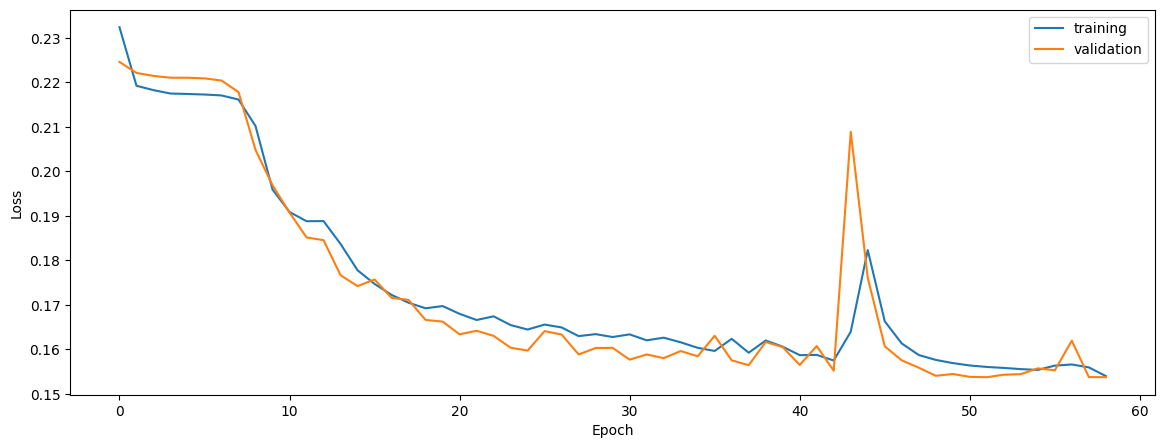

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1t2','fe':['k5_b25']}]
    props['balance_data'] = False
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

0.6193818040435459
0.6588874392657909
0.5886523275598796


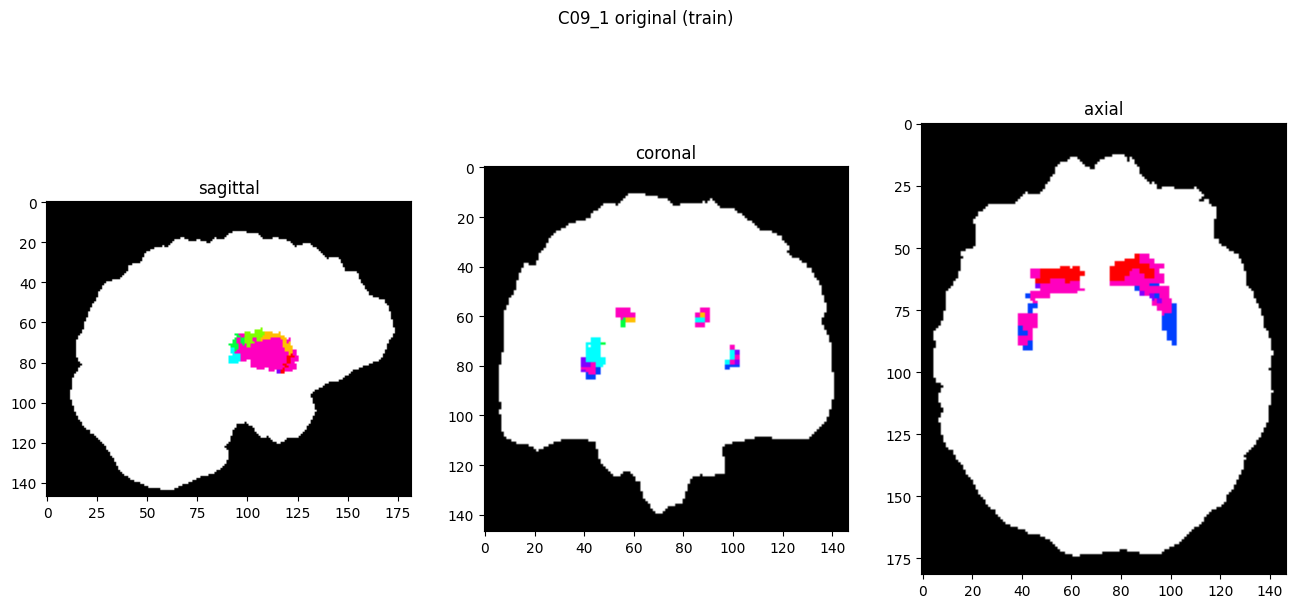

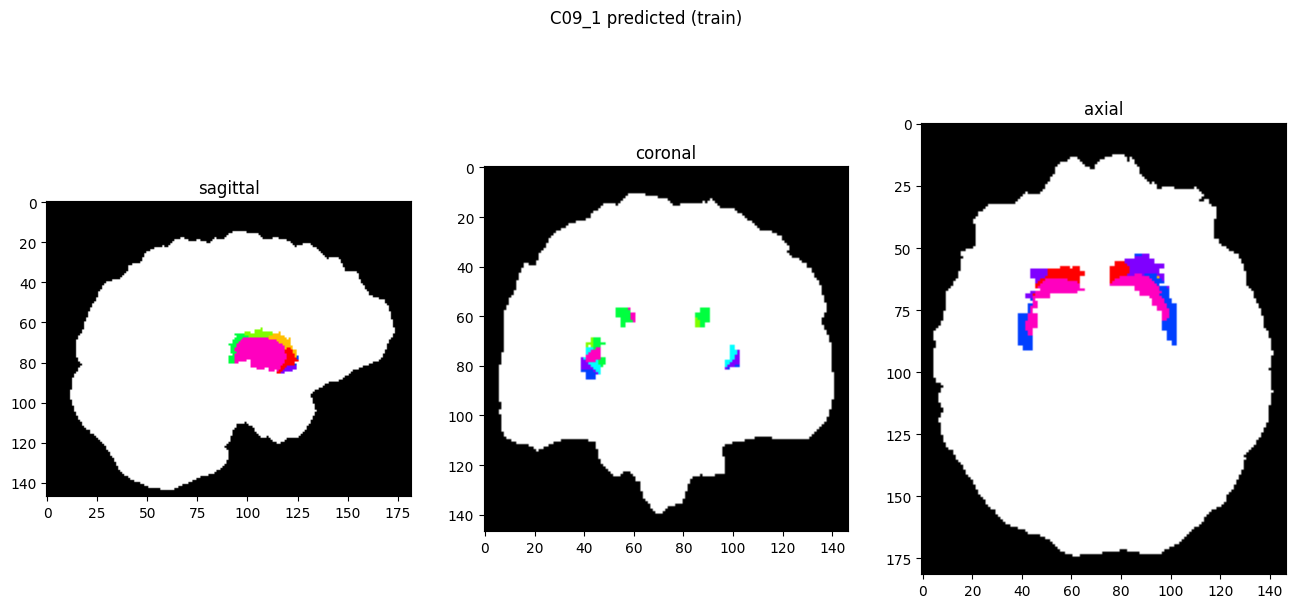

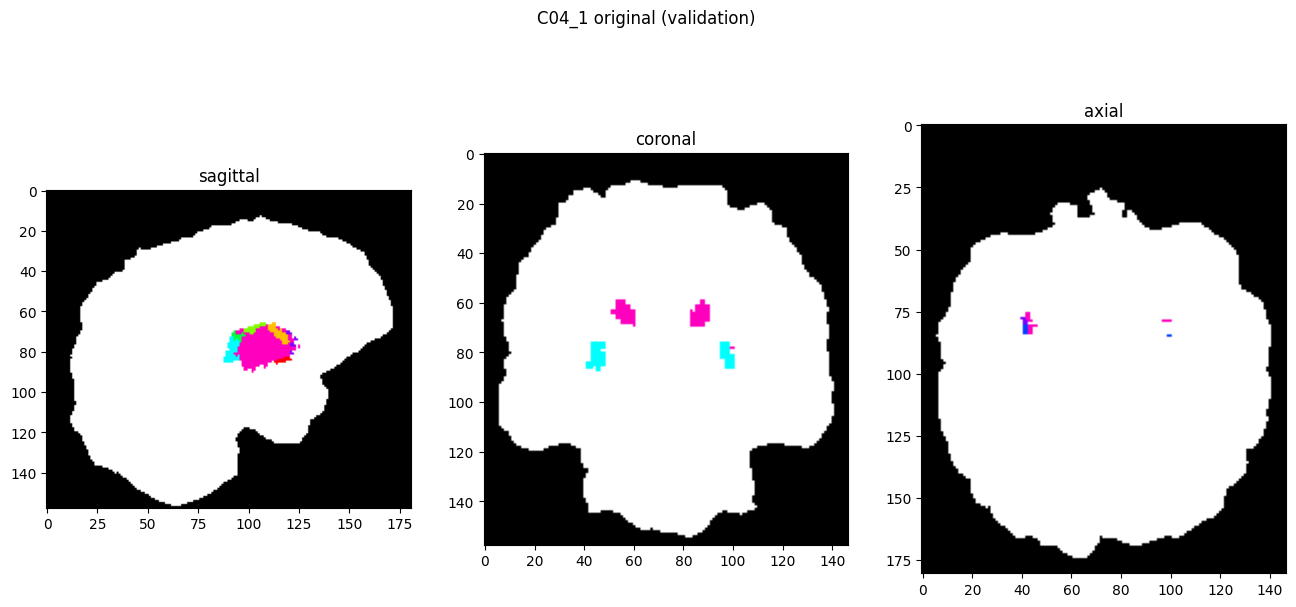

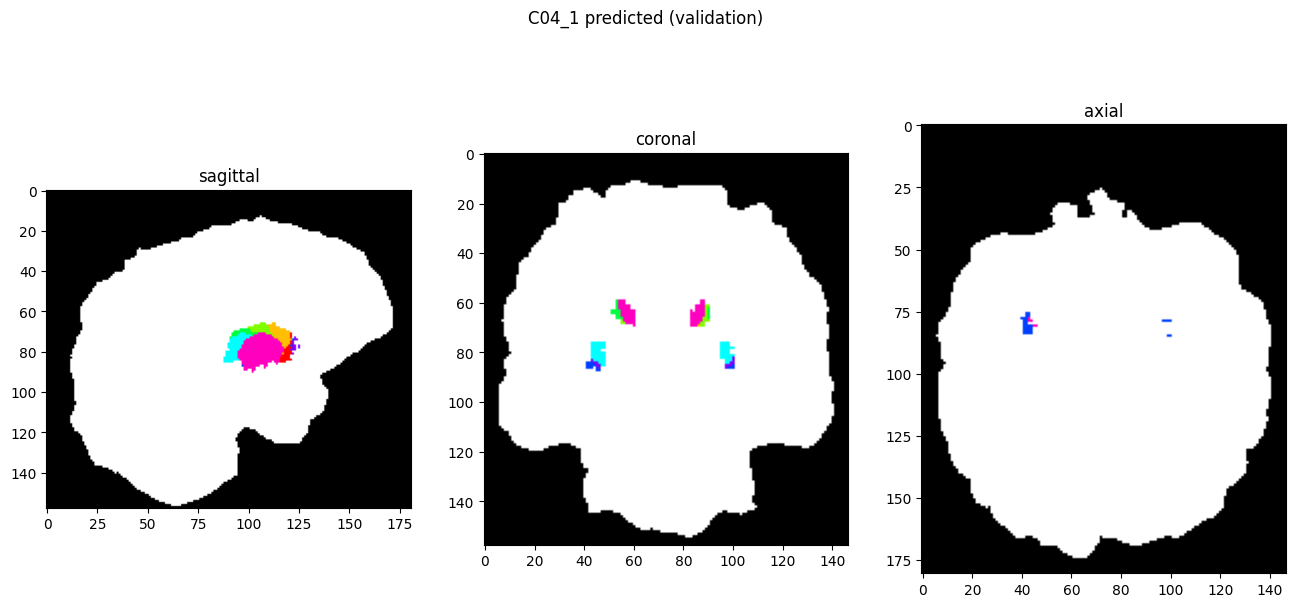

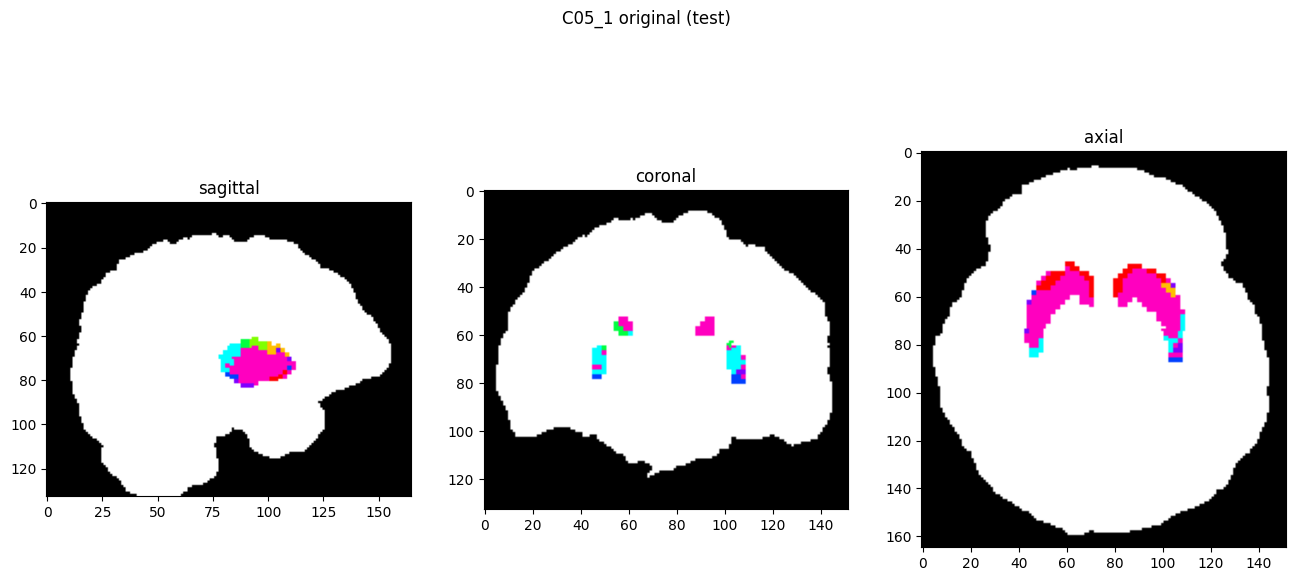

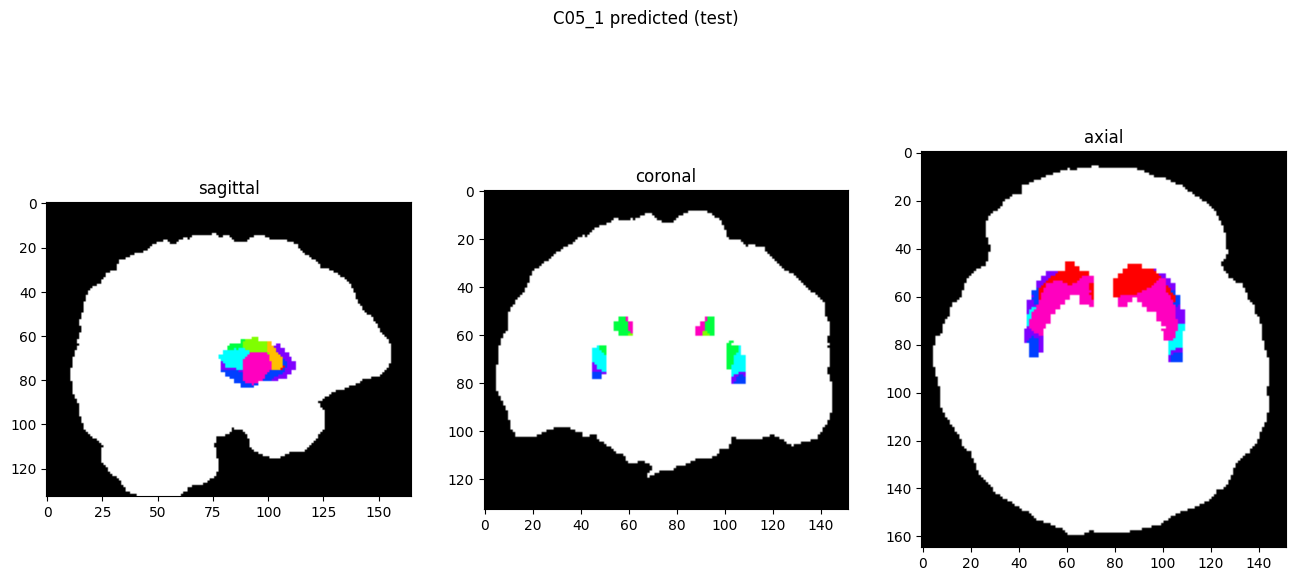

In [16]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)